In [1]:
import torch
import numpy as np
import matplotlib.pylab  as plt
from mpl_toolkits.mplot3d import Axes3D
from train_VAE import Net
from Data import ShapeNet_2048
from torch_geometric.data import DataLoader
%matplotlib inline

In [2]:
path = '../data/shapenet_2048/'
batch_size = 32
dataset = ShapeNet_2048(path, split='trainval',categories='Chair')
device = torch.device('cuda')
model = Net().to(device)
test_loader = DataLoader(
    dataset, batch_size=batch_size, shuffle=False, num_workers=1)
model.load_state_dict(torch.load('pointVAECh10.pt',map_location=device))

RuntimeError: Error(s) in loading state_dict for Net:
	size mismatch for sa3_module.nn.1.0.weight: copying a param with shape torch.Size([512, 256]) from checkpoint, the shape in current model is torch.Size([256, 256]).
	size mismatch for sa3_module.nn.1.0.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for sa3_module.nn.1.2.weight: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for sa3_module.nn.1.2.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for sa3_module.nn.1.2.running_mean: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for sa3_module.nn.1.2.running_var: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for sa3_module.nn.2.0.weight: copying a param with shape torch.Size([1024, 512]) from checkpoint, the shape in current model is torch.Size([512, 256]).
	size mismatch for sa3_module.nn.2.0.bias: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for sa3_module.nn.2.2.weight: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for sa3_module.nn.2.2.bias: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for sa3_module.nn.2.2.running_mean: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for sa3_module.nn.2.2.running_var: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for mu_lin.weight: copying a param with shape torch.Size([100, 1024]) from checkpoint, the shape in current model is torch.Size([20, 512]).
	size mismatch for mu_lin.bias: copying a param with shape torch.Size([100]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for sig_lin.weight: copying a param with shape torch.Size([100, 1024]) from checkpoint, the shape in current model is torch.Size([20, 512]).
	size mismatch for sig_lin.bias: copying a param with shape torch.Size([100]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for lin1.weight: copying a param with shape torch.Size([1024, 100]) from checkpoint, the shape in current model is torch.Size([512, 20]).
	size mismatch for lin1.bias: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for lin2.weight: copying a param with shape torch.Size([2048, 1024]) from checkpoint, the shape in current model is torch.Size([1024, 512]).
	size mismatch for lin2.bias: copying a param with shape torch.Size([2048]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for lin3.weight: copying a param with shape torch.Size([6144, 2048]) from checkpoint, the shape in current model is torch.Size([6144, 1024]).

In [ ]:
gen_data = {
    'pred': np.empty([len(dataset),2048,3]),
    'true': np.empty([len(dataset),2048,3])
}
model.eval()
for i,data in enumerate(test_loader):
    data = data.to(device)
    with torch.no_grad():
        begin = i*batch_size
        end = begin +data.category.size(0)
        gen_data['pred'][begin:end] = model(data)[0].cpu().numpy().reshape((-1,2048,3))
        gen_data['true'][begin:end] = data.x.cpu().numpy().reshape((-1,2048,3)) 

In [6]:
i

184

In [7]:
def plot_3d_point_cloud(x, y, z, show=True, show_axis=True, in_u_sphere=False, marker='.', s=8, alpha=.8, figsize=(15, 7), elev=10, azim=240, axis=None, title=None, *args, **kwargs):

    if axis is None:
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111, projection='3d')        
    else:
        ax = axis
        fig = axis

    if title is not None:
        plt.title(title)

    sc = ax.scatter(x, y, z, marker=marker, s=s, alpha=alpha, *args, **kwargs)
    ax.view_init(elev=elev, azim=azim)

    if in_u_sphere:
        ax.set_xlim3d(-0.5, 0.5)
        ax.set_ylim3d(-0.5, 0.5)
        ax.set_zlim3d(-0.5, 0.5)
    else:
        miv = 0.7 * np.min([np.min(x), np.min(y), np.min(z)])  # Multiply with 0.7 to squeeze free-space.
        mav = 0.7 * np.max([np.max(x), np.max(y), np.max(z)])
        ax.set_xlim(miv, mav)
        ax.set_ylim(miv, mav)
        ax.set_zlim(miv, mav)
        plt.tight_layout()

    if not show_axis:
        plt.axis('off')

    if 'c' in kwargs:
        plt.colorbar(sc)

    if show:
        plt.show()

    return fig

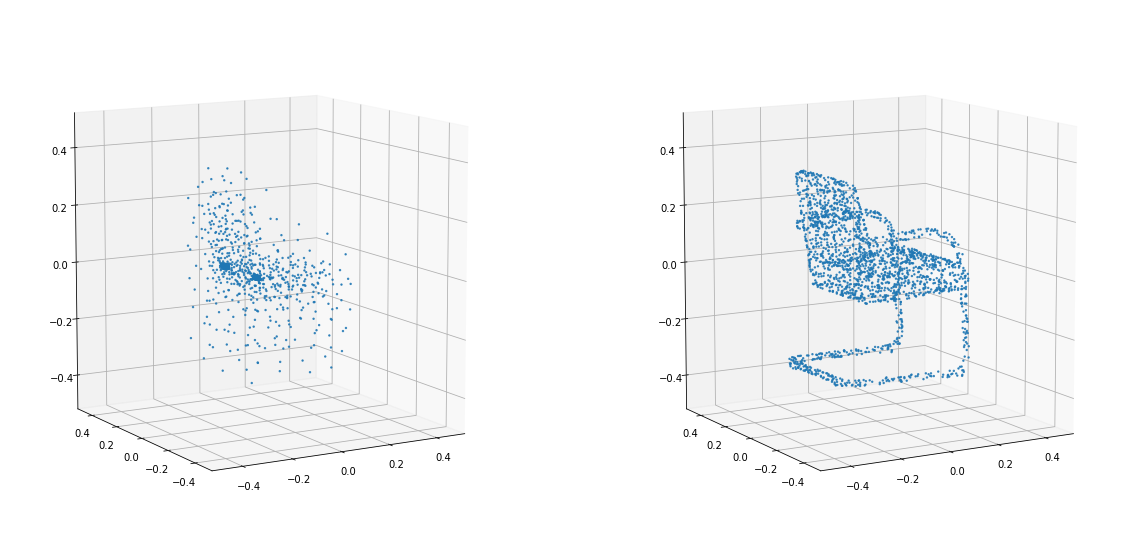

In [8]:
fig = plt.figure(figsize=(20,10))
ax_pred = fig.add_subplot(121, projection='3d')
ax_true = fig.add_subplot(122, projection='3d')
num = 300
plot_3d_point_cloud(gen_data['pred'][num][:,0], 
                    gen_data['pred'][num][:,1], 
                    gen_data['pred'][num][:,2], in_u_sphere=True,axis=ax_pred,show=False);
plot_3d_point_cloud(gen_data['true'][num][:,0], 
                    gen_data['true'][num][:,1], 
                    gen_data['true'][num][:,2], in_u_sphere=True,axis=ax_true,show=False);

In [22]:
gen_data['pred'][1]

array([[-0.12863798, -0.16573569, -0.00746617],
       [-0.12776695, -0.16948399, -0.0044901 ],
       [-0.12757702,  0.16283967, -0.00344484],
       ...,
       [-0.12548396,  0.16608946, -0.01240713],
       [-0.16946052,  0.18517882,  0.02817492],
       [-0.1258128 , -0.17164917, -0.00968657]])

In [23]:
gen_data['pred'][2]

array([[-0.13617271, -0.16917305, -0.01567934],
       [-0.13804057, -0.17385423, -0.00911763],
       [-0.13652216,  0.1666837 , -0.00818287],
       ...,
       [-0.13387202,  0.1689861 , -0.02054919],
       [-0.17740509,  0.1832469 ,  0.01277673],
       [-0.13409755, -0.17627273, -0.01787825]])